In [1]:
import matplotlib.pyplot as plt
from os import walk

import json
from matplotlib.ticker import MultipleLocator
from pennylane import numpy as np

plt.ioff() ## To display image only when required - plt.show()

FILES_NAMES = {"simplified_2_design":{"fd":[  "simplified2design_4layers_fd_0"],"ps":["simplified2design_4layers_ps_0"]},
               "single_double":{"fd":["meta_single_doubles_fd_0"],"ps":["meta_single_doubles_ps_0"]},
               "double":{"fd":["meta_doubles_fd_0"],"ps":["meta_doubles_ps_0"]},               
               "kupccgsd":{"fd":["kupccgsd_1layers_fd_0"],"ps":["kupccgsd_1layers_ps_0"]}}

DATA = {i:{"fd":[],"ps":[]} for i in FILES_NAMES}

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)   

DICT_GRAD_METHOD = {"fd":"Finite Diff", "ps":"Parameter Shift"}
DICT_ANSATZ = {"simplified_2_design":"Simplified Two Design 4 Layers", "single_double": "Single & Double Excitations", "double": "Double Excitations", "kupccgsd":"k-UpCCGSD 1 layer"}

optimizers = ["gradient_descent", "spsa", "adam", "demon_adam"]
train_types= ['vqe_random', 'vqe','meta', 'opt_meta']
all_ansatz = ["simplified_2_design", "single_double", "double", "kupccgsd"]


test_points=fci_h2["points"]
fci_energies = fci_h2["energies"]
    

In [2]:
for ansatz in FILES_NAMES:
    for diff_method in FILES_NAMES[ansatz]:
        for file in FILES_NAMES[ansatz][diff_method]:
            with open(f'./{file}.json', 'r') as reader:
                # Read & print the entire file
                data = reader.read()
                DATA[ansatz][diff_method].append(json.loads(data))


In [3]:
f = []
for (dirpath, dirnames, filenames) in walk('./'):
    f.extend(filenames)
    break

# Ordered by pairs - fd,ps
main_groups = [ "simplified2design_4layers_fd", "simplified2design_4layers_ps", "meta_single_doubles_fd", "meta_single_doubles_ps", "meta_doubles_fd", "meta_doubles_ps", "kupccgsd_1layers_fd", "kupccgsd_1layers_ps", ]

In [4]:
condensed_data = { i:{} for i in all_ansatz}
ansatz_counter = 0

for group_count,file_name_base in enumerate(main_groups):
    this_group = []
    files_in_group = [f_name for f_name in f if file_name_base in f_name]
    for file_name in files_in_group:
        with open(f'./{file_name}', 'r') as reader:
            # Read & print the entire file
            data = reader.read()
            this_group.append(json.loads(data))    
    
    group_dict = {i:[] for i in optimizers}
    for opt in optimizers:
        opt_energies = []
        for data_entry in this_group:
            opt_energies.append([energy[-1] for energy in data_entry['results'][opt]['vqe']["energies"]])
        group_dict[opt] = np.sum(opt_energies, axis=0)/len(opt_energies)
    
    if group_count!=0 and group_count%2==0:
        ansatz_counter+=1
    condensed_data[all_ansatz[ansatz_counter]][file_name_base[-2:]]= group_dict
    



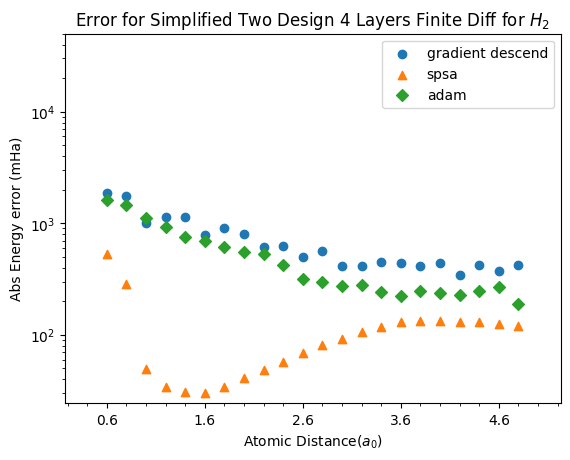

In [10]:
GRAD_METHOD_COMP = "fd" ## "fd" or "ps"
REF_ANSATZ = all_ansatz[0]

error_gradient = [np.abs(i-j)*1000 for i,j in zip(condensed_data[REF_ANSATZ][GRAD_METHOD_COMP][optimizers[0]],fci_energies)]
error_spsa = [np.abs(i-j)*1000 for i,j in zip(condensed_data[REF_ANSATZ][GRAD_METHOD_COMP][optimizers[1]],fci_energies)]
error_adam = [np.abs(i-j)*1000 for i,j in zip(condensed_data[REF_ANSATZ][GRAD_METHOD_COMP][optimizers[2]],fci_energies)]

# Plot for errors
fig, ax = plt.subplots()

ax.scatter(test_points,error_gradient, label="gradient descend", marker='o')
ax.scatter(test_points,error_spsa, label="spsa", marker='^')
ax.scatter(test_points,error_adam, label="adam", marker='D')


ax.legend()
ax.set_title(f'Error for {DICT_ANSATZ[REF_ANSATZ]} {DICT_GRAD_METHOD[GRAD_METHOD_COMP]} for $H_{2}$')
ax.set_yscale('log',base=10) 
ax.set_ylabel('Abs Energy error (mHa)')
ax.set_xlabel('Atomic Distance($a_{0}$)')
ax.set_ylim(top=5e4)

ax.hlines(y=1.6, xmin=test_points[0] -0.2, xmax=test_points[-1]+0.2, linestyles='--', linewidth=2, color='black')
ax.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xticks(np.arange(min(test_points), max(test_points)+0.2, 1))

plt.show()



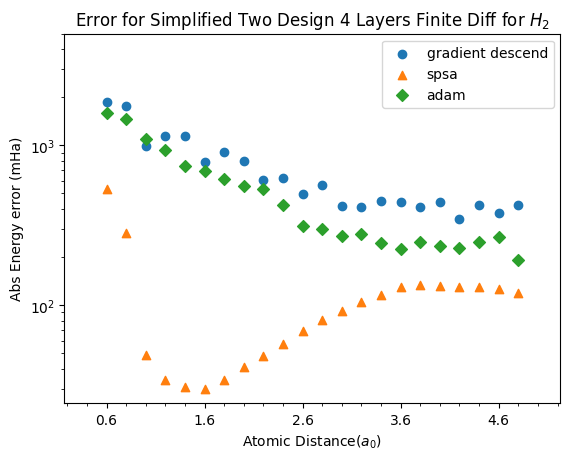

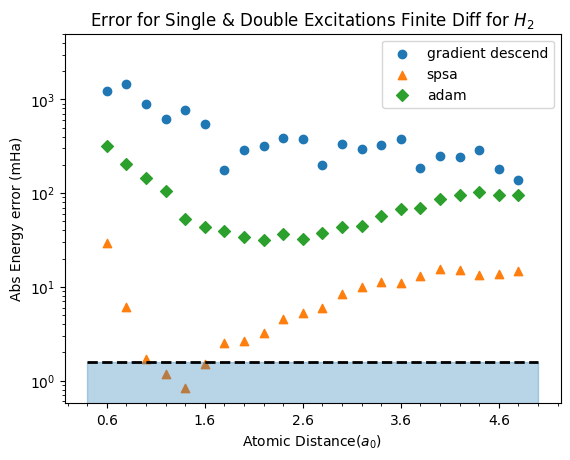

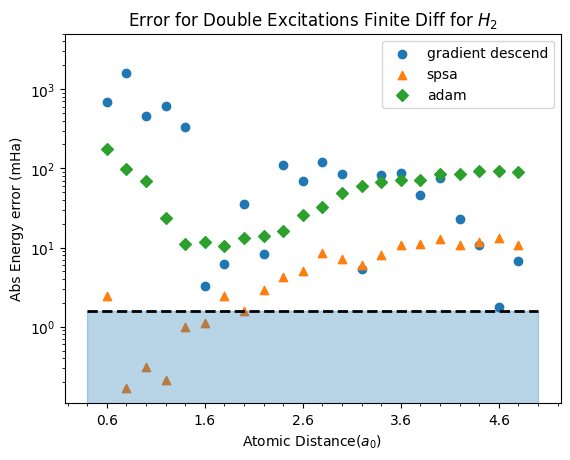

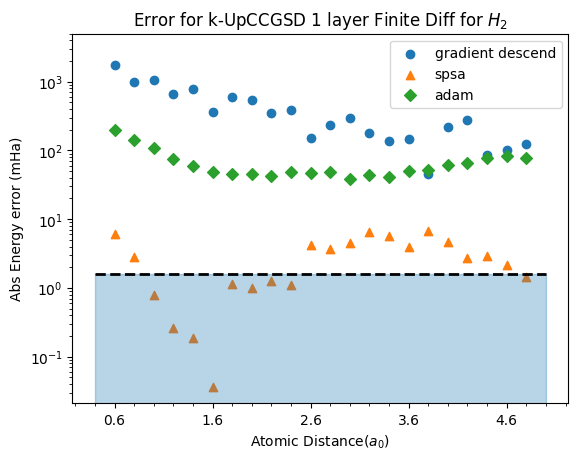

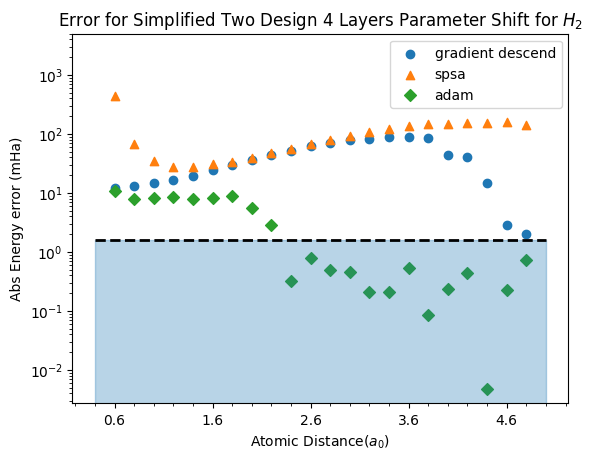

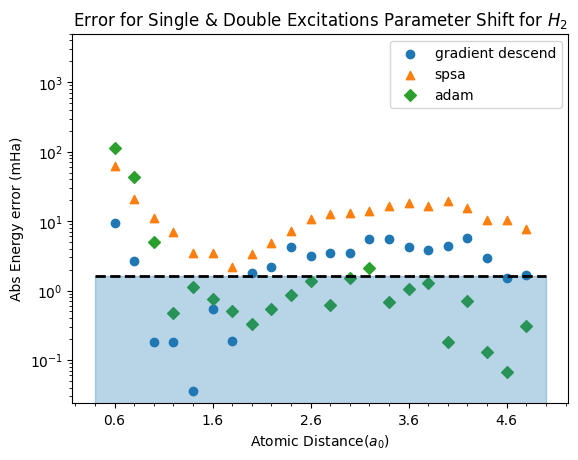

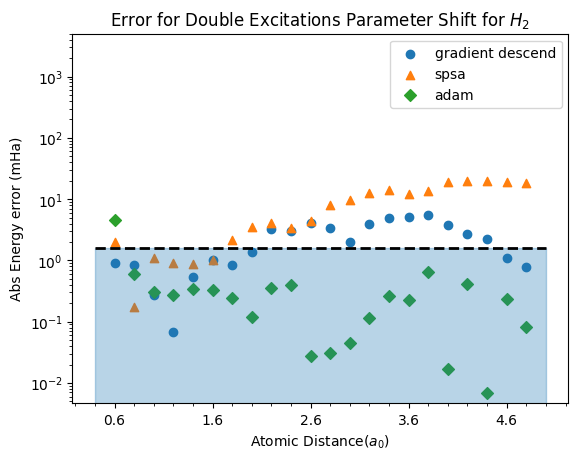

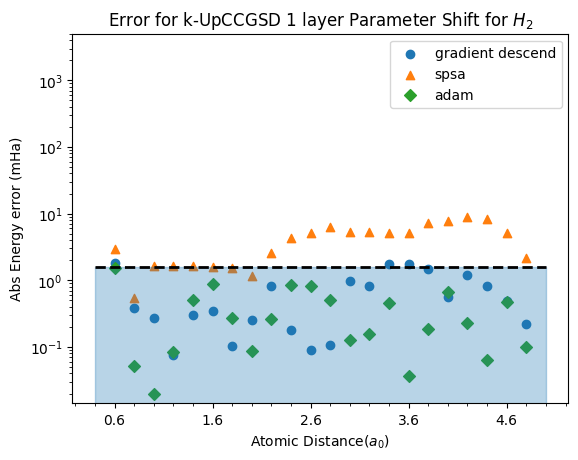

In [11]:
for grad_method in DICT_GRAD_METHOD.keys():
    for ansatz_circ in DICT_ANSATZ.keys():

        error_gradient = [np.abs(i-j)*1000 for i,j in zip(condensed_data[ansatz_circ][grad_method][optimizers[0]],fci_energies)]
        error_spsa = [np.abs(i-j)*1000 for i,j in zip(condensed_data[ansatz_circ][grad_method][optimizers[1]],fci_energies)]
        error_adam = [np.abs(i-j)*1000 for i,j in zip(condensed_data[ansatz_circ][grad_method][optimizers[2]],fci_energies)]        

        # Plot for errors
        fig, ax = plt.subplots()

        ax.scatter(test_points,error_gradient, label="gradient descend", marker='o')
        ax.scatter(test_points,error_spsa, label="spsa", marker='^')
        ax.scatter(test_points,error_adam, label="adam", marker='D')


        ax.legend()
        ax.set_title(f'Error for {DICT_ANSATZ[ansatz_circ]} {DICT_GRAD_METHOD[grad_method]} for $H_{2}$')
        ax.set_yscale('log',base=10) 
        ax.set_ylabel('Abs Energy error (mHa)')
        ax.set_xlabel('Atomic Distance($a_{0}$)')
        ax.set_ylim(top=5e3)

        ax.hlines(y=1.6, xmin=test_points[0] -0.2, xmax=test_points[-1]+0.2, linestyles='--', linewidth=2, color='black')
        ax.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax.set_xticks(np.arange(min(test_points), max(test_points)+0.2, 1))

        plt.savefig(f'vqe_shots_{ansatz_circ}_{grad_method}.png')